<a href="https://colab.research.google.com/github/simonsavine/phasetype/blob/main/ctmarkov_chain_simulation_continuous_timemc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Helper functions

In [3]:
def is_square(Q):
  shape = np.shape(Q)

  if len(shape) != 2:
    return False

  return shape[0] == shape[1]

In [5]:
def is_proba_vector(P):
  if np.any(P < 0):
    return False

  return np.isclose(np.sum(P),1)

In [6]:
# we only accept n by n intensity matrices with exactly 1 absorbing state n
def is_intensity_matrix(Q):
  if not is_square(Q):
    return False

  # check that off-diagonals are non-negative
  n = np.shape(Q)[0]
  for j in range(n):
    for k in range(j):
      if Q[j, k] < 0 or Q[k, j] < 0:
        return False

  # check diagonals
  diag = np.diag(Q)
  # last diagonal must be 0 (absorbing)
  if diag[-1] != 0:
    return False
  # all other diagonals must be non-zero (non-absorbing)
  if np.any(diag[:-1] >= -1e-8):
    return False

  # check that all columns sum to 0
  if np.allclose(Q.sum(axis=1), 0):
    return False

  return True

In [7]:
def is_diagonalizable(Q):
  if not is_square(Q):
    return False

  ls, V = np.linalg.eig(Q)

  return np.abs(np.linalg.det(V)) > 1e-4

In [60]:
def make_random_probability_vector(n):
  P = np.random.uniform(size=n)
  return P / P.sum()


# we draw intensities with exponential distribution
# by default, scale = 0.25, lambda = 4
def make_random_intensity_matrix(n, scale = 0.1, absorbing=True, diagonalizable=True):
  # random intensities between 0 and 1
  Q = np.random.exponential(scale = scale, size = (n, n))
  # set diagonal intensities such that columns sum to 0
  for k in range(n):
    Q[k, k] = 0
    Q[k, k] = - Q[:, k].sum()
  # absorbing column
  if absorbing:
    Q[:, n-1] = 0

  if diagonalizable and not is_diagonalizable(Q):
    return make_random_intensity_matrix(n, scale, absorbing, True)

  return Q




In [61]:
# Helper functions

In [328]:
class CTMC:

  def __init__(self, P0, Q):

    assert is_proba_vector(P0), 'not a probability vector'
    assert is_intensity_matrix(Q), 'not an intensity matrix'
    assert is_diagonalizable(Q), 'not diagonalizable'
    assert P0.shape[0] == Q.shape[0], 'inconsistent shapes'

    self.n = np.shape(Q)[0]

    self.P0 = P0
    self.Q = Q
    self.lams, self.V = np.linalg.eig(Q)
    self.invV = np.linalg.inv(self.V)

  # 1. helper to compute exp(Q t), see section 1.1 of document

  # calculate exp(Qt)
  def calc_matrix_exp(self, t):
    # dump (numerical) imaginary part, eigenvalues of intensity matrices are always real
    return np.real(self.V @ np.diag(np.exp(self.lams * t)) @ self.invV)

  # 2. compute probabilities of CTMC states, and absorption time
  # see sections 2 and 3

  # calculate P(T2) as a function of P(T1)
  def calc_probas(self, T2, T1=0., P1 = None):
    if P1 is None:
      P1 = self.P0
    return self.calc_matrix_exp(T2 - T1) @ P1

  # calculate Pr(X2 | X1 = k)
  def calc_probas_definitestate(self, delta_T, k):
    return self.self.calc_matrix_exp(delta_T) [:, k]

  # calculate distribution of absorption time (i.e. Phase-Type)
  def calc_phase_type_cdf(self, t):
    return self.calc_probas(t)[-1]
  def calc_phase_type_pdf(self, t):
    return (self.calc_matrix_exp(t) @ self.Q @ self.P0)[-1]

  # simulate CTMC and sample absorption time, see section 4

  # draw holding time
  def draw_holding_time(self, k):
    return np.random.exponential(scale = - 1 / self.Q[k, k])

  # draw next state
  def draw_next_state(self, k):
    probas = - self.Q[:, k] / self.Q[k, k]
    probas[k] = 0
    return np.random.choice(self.n, p = probas)

  def sample_path(self):
    # draw initial state
    time = 0
    state = np.random.choice(self.n, p=self.P0)
    path = [(time, state)]

    # iterate until hitting absorbing state
    while state != self.n-1:
      tau = self.draw_holding_time(state)
      time += tau
      state = self.draw_next_state(state)
      path.append((time, state))

    return np.array(path).T

  def sample_paths(self, N=1000):
    paths = []
    for _ in range(N):
      paths.append(self.sample_path())
    return paths



In [299]:
# first tests

In [330]:
# pick P0 and Q

n = 4
P0 = make_random_probability_vector(n)
Q = make_random_intensity_matrix(n)

In [331]:
P0

array([0.32694953, 0.09166485, 0.50325088, 0.07813474])

In [332]:
Q

array([[-0.41088204,  0.04005097,  0.05912658,  0.        ],
       [ 0.18873627, -0.2415559 ,  0.11175895,  0.        ],
       [ 0.1571543 ,  0.08360386, -0.18654567,  0.        ],
       [ 0.06499146,  0.11790108,  0.01566014,  0.        ]])

In [333]:
# sample a path

ctmc = CTMC(P0, Q)
ctmc.sample_path()

array([[0.        , 5.02499206, 5.9063553 , 6.6335818 , 7.38897254,
        7.63664617],
       [2.        , 0.        , 1.        , 0.        , 1.        ,
        3.        ]])

In [335]:
# sample multiple paths

ctmc.sample_paths(5)

[array([[ 0.        ,  4.6104721 , 10.15962894, 13.1857798 , 14.70114229,
         17.06184669, 17.82696644, 18.11939031, 19.28033436, 23.81960044,
         28.68214683, 29.78615646, 32.27196982],
        [ 2.        ,  0.        ,  1.        ,  0.        ,  2.        ,
          1.        ,  0.        ,  2.        ,  1.        ,  2.        ,
          0.        ,  1.        ,  3.        ]]),
 array([[0.        , 0.6071669 , 3.34610284],
        [2.        , 0.        , 3.        ]]),
 array([[ 0.        ,  3.28072339, 10.48592199, 30.82167564, 32.56978224,
         34.12894062],
        [ 2.        ,  1.        ,  2.        ,  1.        ,  0.        ,
          3.        ]]),
 array([[ 0.        , 10.65884274, 14.3687211 , 16.0529379 , 18.6568735 ,
         24.3495278 , 29.60528406, 31.27702942, 33.07367049, 33.43209165,
         34.69147339, 49.41322478, 51.89942738, 54.83586057],
        [ 2.        ,  1.        ,  0.        ,  2.        ,  1.        ,
          2.        ,  1.     

In [305]:
# helper functions to analyse paths

In [306]:
def get_state(path, t):
  times = path[0, :]
  states = path[1, :].astype(int)
  return states[np.searchsorted(times, t, side="right") - 1]

In [307]:
def get_absorption_time(path):
  times = path[0, :]
  return times[-1]

In [336]:
# sizeable sample

N = 1000
paths = ctmc.sample_paths(N)

In [337]:
# check state probabilities

In [338]:
t = 5
theoretical_probas = ctmc.calc_probas(t)
theoretical_probas

array([0.11088174, 0.24993764, 0.3448513 , 0.29432933])

In [339]:
states = []
for path in paths:
  states.append(get_state(path, t))
states, empirical_probas = np.unique(states, return_counts=True)
empirical_probas = empirical_probas / N
empirical_probas

array([0.122, 0.268, 0.338, 0.272])

In [340]:
# check distribution of absorption time

In [341]:
abs_times = []
for path in paths:
  abs_times.append(get_absorption_time(path))
abs_times = np.array(abs_times)
abs_times.sort()

In [342]:
largest = abs_times[-1]
largest

102.34581153810053

In [343]:
bins = 100
ts = np.linspace(1e-8, largest, bins)
h = largest / bins
theoretical_densities = [ctmc.calc_phase_type_pdf(t) for t in ts]


In [344]:
empirical_densities = [0]
for i in range(1, len(ts)):
  t0 = ts[i-1]
  t1 = ts[i]
  count = np.count_nonzero((abs_times >=t0) & (abs_times < t1))
  empirical_densities.append(count)
empirical_densities = np.array(empirical_densities) / h / N
empirical_densities[0] = empirical_densities[1]

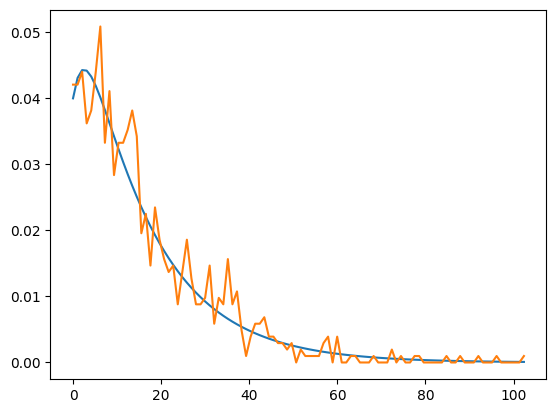

In [345]:
plt.plot(ts, theoretical_densities)
plt.plot(ts, empirical_densities)
